In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE,BorderlineSMOTE, ADASYN
import joblib


In [2]:
df = pd.read_csv('tyg3.csv')
df.head()

,subject_id,hadm_id,stay_id,intime,age,gender,race,los,diabetes,hypertension,...,has_ercp,has_vasopressin,los_icu,los_hosp,hosp_mortality,icu_mortality,mortality_7d,mortality_28d,mortality_90d,mortality_1y
0,10004606,29242151,30213599,2159-02-20 16:10:03,64,F,WHITE,5.166100,0,1,...,0,0,5.166100,14.130556,0,0,0,0,0,0
1,10006441,24120560,37240744,2174-09-12 16:57:04,51,M,WHITE,0.776481,0,0,...,0,0,0.776481,15.834722,0,0,0,0,0,0
2,10007795,28477357,31921355,2136-04-22 18:01:13,53,F,WHITE,1.050521,0,1,...,0,0,1.050521,21.834722,0,0,0,0,0,0
3,10010888,20162667,33318955,2174-01-09 00:21:00,43,M,WHITE,9.019225,1,0,...,0,0,9.019225,17.736806,0,0,0,0,0,0
4,10012206,23961896,37675714,2127-07-04 02:08:00,45,M,WHITE,0.572477,1,1,...,0,0,0.572477,10.655556,0,0,0,0,0,0


In [3]:
encoder = OrdinalEncoder()
df[['gender', 'race']] = encoder.fit_transform(df[['gender', 'race']])

In [4]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'age', 'gender', 'race',
       'los', 'diabetes', 'hypertension', 'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
       'ast', 'pt', 'ptt', 'inr', 'neutrophils_max', 'neutrophils_min',
       'albumin_max', 'albumin_min', 'bun_max', 'bun_min', 'sepsis',
       'sepsis_3', 'npar', 'tyg', 'sofa', 'has_sepsis', 'aki',
       'has_chronic_kidney_disease', 'has_crrt', 'has_mv', 'has_ercp',
       'has_vasopressin', 'los_icu', 'los_hosp', 'hosp_mortality',
       'icu_mortality', 'mortality_7d', 'mortality_28d', 'mortality_90d',
       'mortality_1y'],
      dtype='object')

In [27]:
cols = [
    'age', 'gender', 'race',
       'diabetes', 'hypertension', 'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
       'ast', 'pt', 'ptt', 'inr', 'sepsis','tyg', 'aki'
]

In [28]:
df['mortality_28d'].value_counts()

mortality_28d
0    558
1    105
Name: count, dtype: int64

In [29]:
imp = IterativeImputer(max_iter=100)
df[cols] = imp.fit_transform(df[cols])

In [31]:
df[cols[:-25]].isna().sum()

age       0
gender    0
dtype: int64

In [32]:
X = df[cols]
y = df['mortality_28d']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2026)

In [33]:
smote = SMOTE(random_state = 2026)
X_res_train, y_res_train = smote.fit_resample(X_train, y_train)
X_train.shape, y_train.shape, X_res_train.shape, y_res_train.shape

C:\Users\nam09\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


((497, 27), (497,), (840, 27), (840,))

In [34]:
y_res_train.value_counts()

mortality_28d
0    420
1    420
Name: count, dtype: int64

In [40]:
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=2026), param_grid={
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [9, 10, 11],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
})
grid.fit(X_train, y_train)
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [41]:
rfc = RandomForestClassifier(random_state=2026, criterion='entropy', max_depth=10, min_samples_leaf=2,min_samples_split=2)
rfc.fit(X_train,y_train)
rfc.score(X_train, y_train), rfc.score(X_test, y_test), 

(0.9899396378269618, 0.8734939759036144)

In [43]:
df_imp = pd.DataFrame({
    'features': rfc.feature_names_in_,
    'importances': rfc. feature_importances_
}).sort_values(by = 'importances', ascending=False)

df_imp.head(10)

,features,importances
15,creatinine,0.085457
11,bicarbonate,0.079246
5,wbc,0.077397
7,rdw,0.057348
0,age,0.057064
20,ast,0.053584
24,sepsis,0.047699
8,hemoglobin,0.045484
13,chloride,0.044786
18,alt,0.041753


In [44]:
rfecv = RFECV(estimator=rfc, scoring='accuracy')
rfecv.fit(X_train, y_train)
rfecv.score(X_test, y_test)

0.8734939759036144

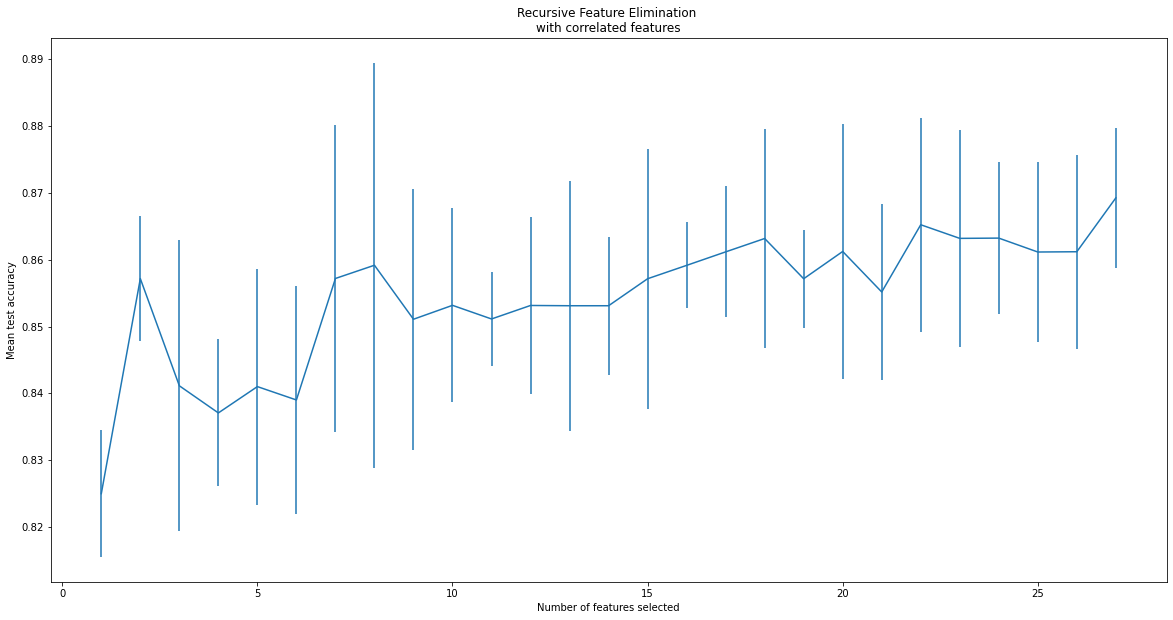

In [45]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure(figsize=(20, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [46]:
rfecv = RFECV(estimator=rfc, scoring='accuracy')
rfecv.fit(X_res_train, y_res_train)
rfecv.score(X_test, y_test)

0.8313253012048193

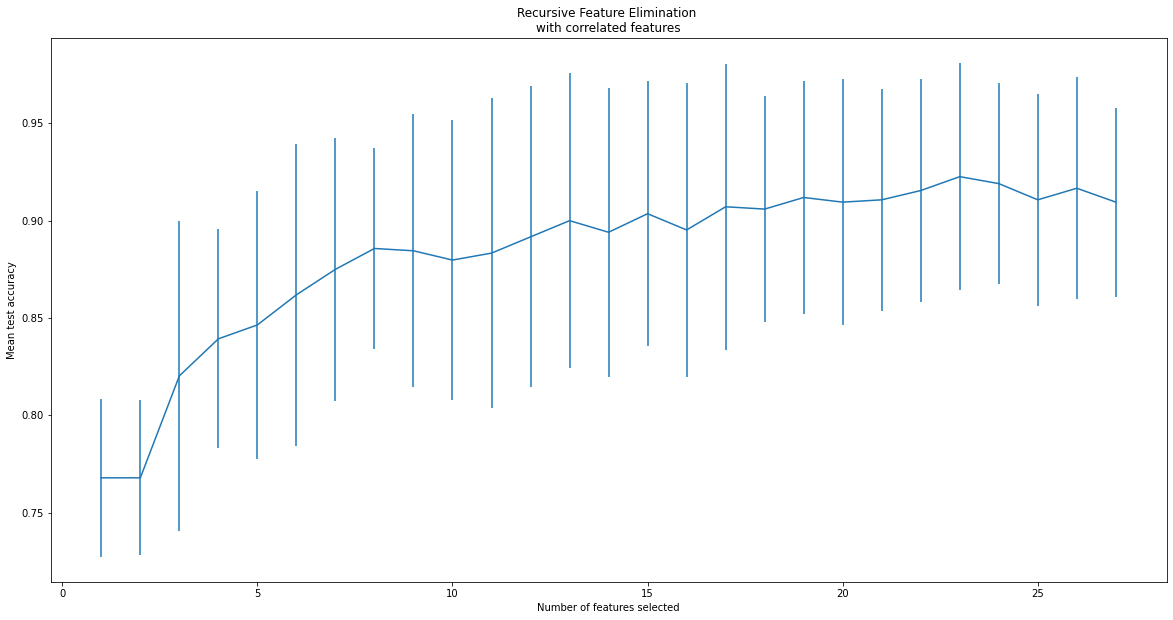

In [47]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure(figsize=(20, 10))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [48]:
rfe = RFE(estimator = rfc , n_features_to_select=12)
rfe.fit(X_res_train, y_res_train)
rfe.score(X_train, y_train), rfe.score(X_test, y_test)

(0.9859154929577465, 0.8554216867469879)

In [49]:
rfe.get_feature_names_out()

array(['age', 'hypertension', 'wbc', 'rdw', 'bicarbonate', 'creatinine',
       'alt', 'alp', 'ast', 'inr', 'sepsis', 'aki'], dtype=object)

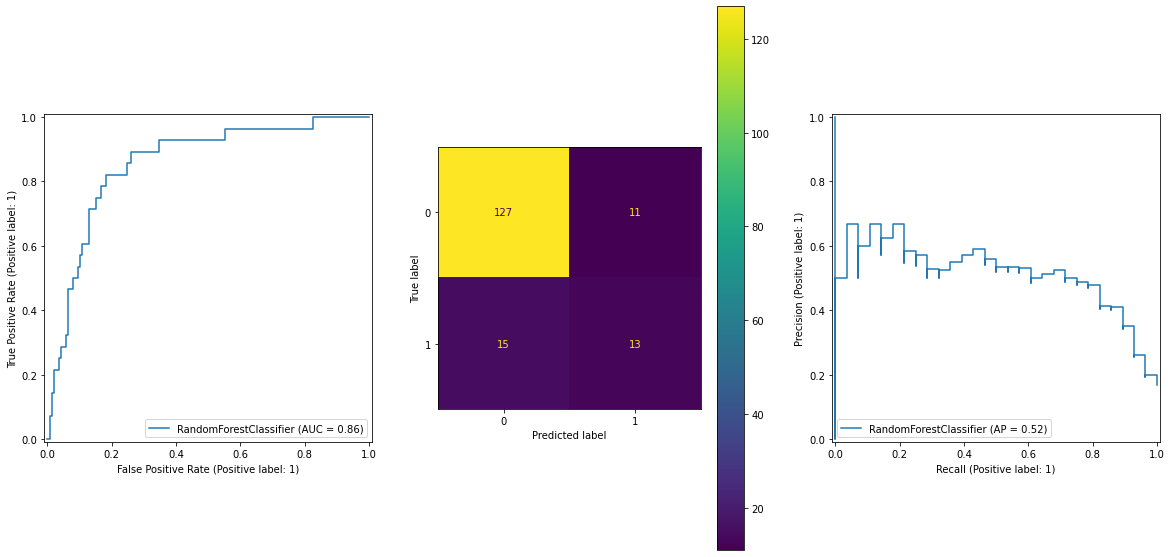

In [50]:
rfc = RandomForestClassifier(random_state=2026, criterion='gini', max_depth=10, min_samples_leaf=1, min_samples_split=3)
rfc.fit(X_res_train, y_res_train)
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 10))
RocCurveDisplay.from_estimator(estimator=rfc, X=X_test, y=y_test, ax=axes[0])
ConfusionMatrixDisplay.from_estimator(estimator=rfc, X=X_test, y=y_test, ax=axes[1])
PrecisionRecallDisplay.from_estimator(estimator=rfc, X=X_test, y=y_test, ax=axes[2])
plt.show()


In [51]:
cols_sel = rfe.get_feature_names_out().tolist()
X_sel = df[cols_sel]
X_sel_train, X_sel_test, y_sel_train, y_sel_test = train_test_split(X_sel, y, random_state=2026)
X_sel_res_train, y_sel_res_train = smote.fit_resample(X_sel_train, y_sel_train)
X_sel_res_train.shape, y_sel_res_train.shape


C:\Users\nam09\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


((840, 12), (840,))

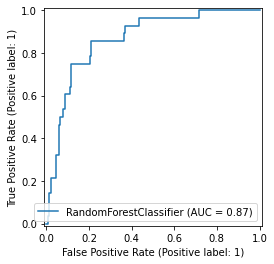

In [52]:
rfc = RandomForestClassifier(random_state=2026, criterion='entropy', max_depth=9, min_samples_leaf=2, min_samples_split=2)
rfc.fit(X_sel_res_train, y_sel_res_train)
RocCurveDisplay.from_estimator(estimator=rfc, X=X_sel_test, y=y_test)
plt.show()


In [56]:
rfc.feature_names_in_

array(['age', 'hypertension', 'wbc', 'rdw', 'bicarbonate', 'creatinine',
       'alt', 'alp', 'ast', 'inr', 'sepsis', 'aki'], dtype=object)

In [61]:
joblib.dump(rfc, 'rfc.joblib')

['rfc.joblib']

In [63]:
joblib.dump(X_sel_res_train, 'X_train.joblib')
joblib.dump(X_sel_res_train, 'y_train.joblib')

['y_train.joblib']

In [64]:
rfe = RFE(estimator=rfc, n_features_to_select=12)
rfe.fit(X_res_train, y_res_train)
rfe.score(X_train, y_train), rfe.score(X_test, y_test)


(0.9798792756539235, 0.8433734939759037)

In [65]:
rfe.get_feature_names_out(), len(rfe.get_feature_names_out())

(array(['age', 'hypertension', 'wbc', 'rdw', 'bicarbonate', 'creatinine',
        'alt', 'alp', 'ast', 'inr', 'sepsis', 'aki'], dtype=object),
 12)

In [67]:
cols_selected = ['age', 'hypertension', 'wbc', 'rdw', 'bicarbonate', 'creatinine',
        'alt', 'alp', 'ast', 'inr', 'sepsis', 'aki']
df[cols_selected].min(), df[cols_selected].max()



(age             20.00000
 hypertension     0.00000
 wbc              1.70000
 rdw             12.00000
 bicarbonate      8.60473
 creatinine       0.30000
 alt              6.00000
 alp             36.00000
 ast             10.00000
 inr              0.90000
 sepsis           0.00000
 aki              0.00000
 dtype: float64,
 age                93.000000
 hypertension        1.000000
 wbc             12500.000000
 rdw                34.900000
 bicarbonate        36.012871
 creatinine         15.200000
 alt              9582.000000
 alp              5006.000000
 ast             33840.000000
 inr                15.600000
 sepsis              1.000000
 aki                 1.000000
 dtype: float64)